# To Scootfinity and Beyond!

## Plan of attack: 
Step 1 will be to load and explore the data and the features. Diving into model building is always thrilling, but first we should explore the feature space, especially looking for potential sources of bias like systematic missing data, highly correlated variables or highly imbalanced variables and any other red flags. The shape of the distributions can give us a hint for which classification algorithm will best suit our data.

[Spoiler alert: right now I'm planning to run a Random Forest given the mixed variable types we have as inputs, and I'm expecting to see some nonlinearities in the feature space... time will tell!]

## Step 1. Data Exploration

In [1]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

In [2]:
#Load the data
url = 'https://raw.githubusercontent.com/clearbrain/clearbrain-data-science-challenge-jessroe88/master/data/conversion_data.csv'
scooter = pd.read_csv(url)
scooter.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


Start by exploring the feature space of our predictor variables

In [3]:
scooter.count() #No missing data! Too good to be true!! That must mean the traps are hiding somewhere else...

country                316200
age                    316200
new_user               316200
source                 316200
total_pages_visited    316200
converted              316200
dtype: int64

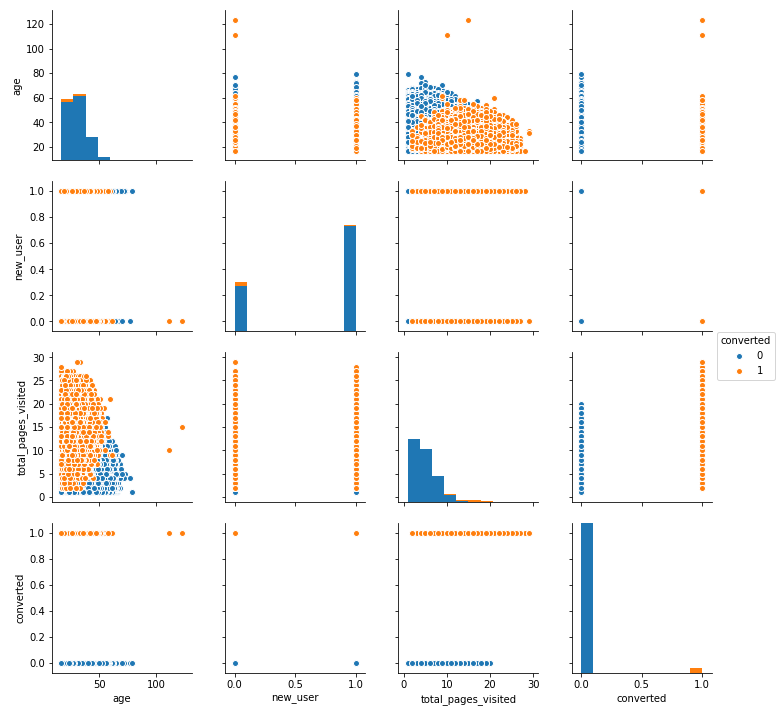

In [4]:
#First just a quick and dirty wall of plots to get a feel for the data (numerical features only)
sns.pairplot(scooter.loc[:,'country':], hue='converted')

The plots above show lots of interesting trends (and a few red flags), and overall there should be enough separation between converted and non-converted to train up a snazzy model.

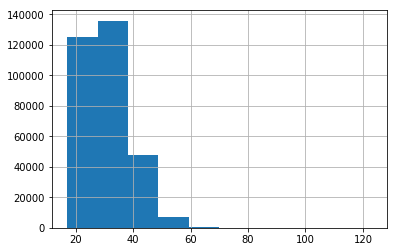

In [5]:
age = scooter['age']
age.hist()

In [6]:
print('Max:', age.max()) #Someone is very old, but the mean and mode are similar, so little skew.
print('Min:', age.min())
print('Mean:', age.mean())
print('Mode:', age.mode()) 

Max: 123
Min: 17
Mean: 30.569857685009488
Mode: 0    30
dtype: int64


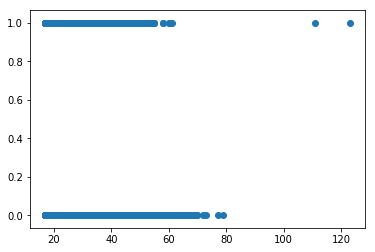

In [7]:
plt.scatter(age,scooter['converted']) #I pity the sigmoid function that has to separate these categories...
#One obvious problem here is that the two extremely old outliers would skew a model in the wrong direction

In [11]:
scooter.groupby('converted').mean()

,age,new_user,total_pages_visited
converted,,,
0,30.703961,0.698382,4.550281
1,26.546765,0.297941,14.553529


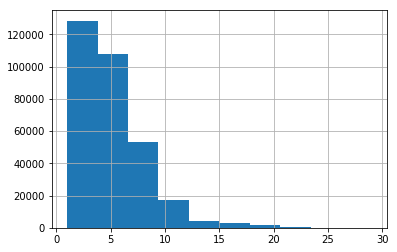

In [10]:
page_visits = scooter['total_pages_visited']
page_visits.hist() #Highly skewed, as suspected. 

In [16]:
print('Max:', page_visits.max()) 
print('Min:', page_visits.min())
print('Mean:', page_visits.mean()) #Very few page visits is common
print('Mode:', page_visits.mode()) #Skew confirmed by mean mode comparison

Max: 29
Min: 1
Mean: 4.872966476913346
Mode: 0    2
dtype: int64


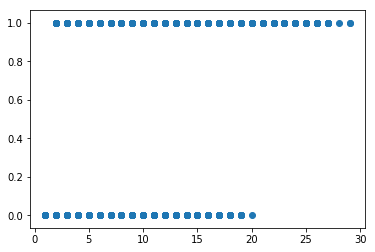

In [17]:
plt.scatter(page_visits,scooter['converted'])
#Stronger signal here, as we would expect - more page views = higher likelihood of conversion

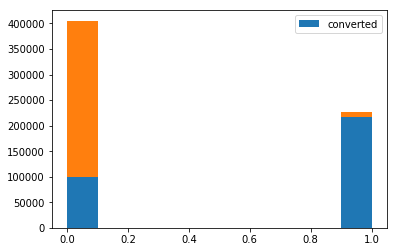

In [119]:
plt.hist([scooter['new_user'],scooter['converted']], stacked=True, label='converted')
plt.legend()
#Converted status on x-axis - new users convert at a far lower rate than returning users
#So far this feature is the strongest looking predictor.


In [122]:
scooter.groupby('converted').count()

,country,age,new_user,source,total_pages_visited
converted,,,,,
0,306000,306000,306000,306000,306000
1,10198,10198,10198,10198,10198


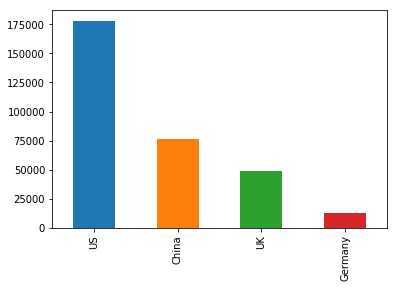

In [26]:
#Now the categorical features
scooter['country'].value_counts().plot(kind='bar')


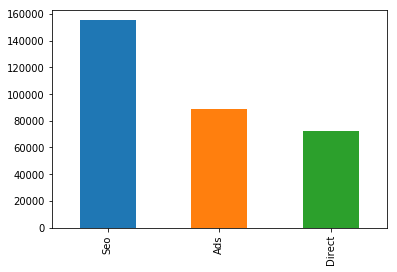

In [27]:
scooter['source'].value_counts().plot(kind='bar')

In [77]:
#Data cleaning - I'm going to remove the two customers who appear to have misreported their age.
#Ordinarily I'd look more closely at their data before cutting them, but I'm treating them as unreliable. 
# My two offenders are 123 and 111. They both converted and they both aren't new users.
scooter = scooter[scooter['age']!=111]
scooter = scooter[scooter['age']!=123]
#Clunky. But removes both offending rows. 


Now let's take a quick peek at our variable of interest to make sure it isn't so skewed that we need to worry about resampling

In [91]:
scooter.groupby('converted').count() #Crap. Will definitely need to resample. 

,country,age,new_user,source,total_pages_visited
converted,,,,,
0,306000,306000,306000,306000,306000
1,10198,10198,10198,10198,10198


## Step 2. Prepare data for modeling.
Nothing I saw convinced me that a random forest wouldn't be a logical place to start, and is more robust to the variable types and underlying distributions than a logistic regression. Let's encode like it's one-hot!

In [79]:
#One-hot encode source and country
hot_source = pd.get_dummies(scooter['source'])
hot_country = pd.get_dummies(scooter['country'])
scooter_hot = pd.concat([scooter, hot_source, hot_country],axis=1)
scooter_hot.head()

,country,age,new_user,source,total_pages_visited,converted,Ads,Direct,Seo,China,Germany,UK,US
0,UK,25,1,Ads,1,0,1,0,0,0,0,1,0
1,US,23,1,Seo,5,0,0,0,1,0,0,0,1
2,US,28,1,Seo,4,0,0,0,1,0,0,0,1
3,China,39,1,Seo,5,0,0,0,1,1,0,0,0
4,US,30,1,Seo,6,0,0,0,1,0,0,0,1


In [80]:
#create new table with fancy new one-hot encoded features
s_table = scooter_hot.drop(['source','country'],axis=1)

In [82]:
s_table.head()

,age,new_user,total_pages_visited,converted,Ads,Direct,Seo,China,Germany,UK,US
0,25,1,1,0,1,0,0,0,0,1,0
1,23,1,5,0,0,0,1,0,0,0,1
2,28,1,4,0,0,0,1,0,0,0,1
3,39,1,5,0,0,0,1,1,0,0,0
4,30,1,6,0,0,0,1,0,0,0,1


### Dataframe made. Time to rebalance classes
I'm going to randomly undersample from the unconverted class, since we have so many samples to work with

In [85]:
num_unconverted, num_converted = s_table.converted.value_counts()

#Divide by class
df_unconverted = s_table[s_table.converted==0]
df_converted = s_table[s_table.converted==1]

In [86]:
df_unconverted_us = df_unconverted.sample(num_converted) #sampling num_converted amount from unconverted groups
s_table_us = pd.concat([df_unconverted_us, df_converted], axis=0)

In [90]:
s_table_us.groupby('converted').count() #Are the groups matched? Yes! 

,age,new_user,total_pages_visited,Ads,Direct,Seo,China,Germany,UK,US
converted,,,,,,,,,,
0,10198,10198,10198,10198,10198,10198,10198,10198,10198,10198
1,10198,10198,10198,10198,10198,10198,10198,10198,10198,10198


In [93]:
feature_table = s_table_us.drop(['converted'],axis=1) #Hiding my outcome variable from my model
feature_table.head()

,age,new_user,total_pages_visited,Ads,Direct,Seo,China,Germany,UK,US
181037,32,1,3,0,0,1,0,0,0,1
130686,21,0,4,0,0,1,0,1,0,0
203685,32,0,2,1,0,0,0,0,0,1
3980,19,0,2,1,0,0,1,0,0,0
207216,20,1,3,0,1,0,1,0,0,0


## Model time

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, cross_val_score

clf = RandomForestClassifier(n_estimators=200, n_jobs=2)
kf=KFold(feature_table.shape[0], n_folds=5, shuffle=True)
score = cross_val_score(clf,np.array(feature_table),np.array(s_table_us['converted']), cv=kf, n_jobs=2)
train_idx, test_idx = next(iter(kf))

In [105]:
clf = clf.fit(np.array(feature_table)[train_idx], s_table_us['converted'].values.astype(int)[train_idx])
predictions = clf.predict(feature_table.values[test_idx])

In [98]:
clf.feature_importances_ #Shows the relative feature importances of each feature

array([0.10068825, 0.07272776, 0.75108181, 0.00262359, 0.00247511,
       0.00269542, 0.05381179, 0.00344554, 0.00510345, 0.00534728])

In [99]:
feature_table.columns #Reminds me what the labels were

Index(['age', 'new_user', 'total_pages_visited', 'Ads', 'Direct', 'Seo',
       'China', 'Germany', 'UK', 'US'],
      dtype='object')

In [100]:
np.mean(score) #92% accuracy overall. Now to investigate whether we trust this. 

0.9242009767868904

Text(0.5,33,'Predicted')

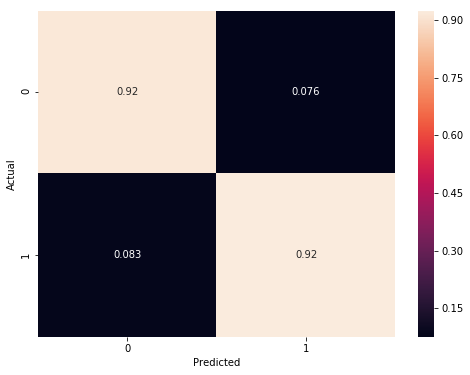

In [109]:
#Confusion matrices to make sure the model isn't labeling everything as converted
from sklearn.metrics import confusion_matrix
targets = s_table_us['converted']
fig = plt.figure(None, (8,6))
mat = confusion_matrix(targets.values[test_idx].astype(int), predictions, labels=[0,1])
sns.heatmap(mat / np.sum(mat, axis=0), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

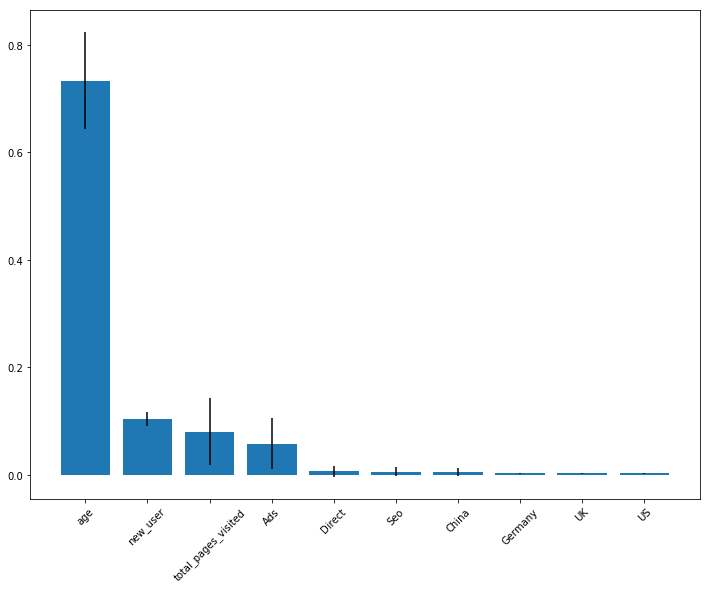

In [115]:
#Plot of relative feature importance
x = feature_table
y = targets

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

feat_importances = []
for f in range(x.shape[1]):
    feat_importances.append(importances[indices[f]])

indices_for_label = feature_table.columns

plt.figure(figsize=(12,9))
plt.bar(range(x.shape[1]),importances[indices], yerr=std[indices])
plt.xticks(range(x.shape[1]), indices_for_label, rotation = 45)
plt.show()

# Conclusions and Insights

We can predict scooter conversion rate, and the DS team is ready to make some recommendations to both the Product and Marketing teams. Once we settle on approaches to focus on, I'll gladly set up experiments with appropriate holdout groups so that we can know with reasonable confidence whether our proposed changes have positive effects, and whether they're worth the cost of deploying/maintaining.

### Marketing: 
Ads *may* be an important marketing channel that converts customers, because ads contribute more to conversion than either direct outreach or search optimization. We should investigate who our ads are reaching and experiment on the best way to expand/double down on our efforts. 

Age is an overwhelmingly important feature that predicts conversion, far more than any of our marketing methods. Younger demographics have a higher conversion probability than older demographics, so we could consider advertising media that preferentially reach younger audiences. 

Another predictor is whether the user already had an account before they came to the site this session. We should investigate what this feature means a bit more, but testing out a targeted marketing campaign focused on getting users back to the site could increase overall conversions.

### Product: 
New User Status and website engagement are two features that the product team should pay attention to. 

New users don't convert at nearly the rate as returning users, so a quick sanity check on the funnel from account creation --> conversion would be smart. Is it straightforward to get from creating the account to getting started with scooters? Is it a quick and easy process so that users can create an account on the go, when they might be most in need of a scooter? 

Total pages visited is another important feature of conversion - people who visited the site but didn't convert visited 4.5 pages on average compared to 14.5 pages on average for people who did convert. This could be correlated with any potential issues or friction in the account creation --> conversion funnel. We should experiment with ways of making our site more engaging and informative, and keep people engaged! Maybe there's other cool content we could play with adding, like data stories based on our ride data or features on some of our riders! 


# Marketing Methodoloty Experiment

The fact that both marketing methods have a statistically significant effect on conversion rate is great news! Even though we can confidently state that both conversion rates are significantly higher than no intervention, given just the information you shared with me, we don't have sufficient evidence and therefore CANNOT claim that the two marketing methodologies are statistically significantly different from each other. If we could look at the data underlying these two experiments, we should be able to directly compare the two methodologies and test them directly against one another, as long as both experiments were run concurrently and there was clear and distinct separation between the two treatment groups (i.e. the groups that saw marketing campaigns). 